# Metro Nashville Disaster Analysis

#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

#### Formatting

In [2]:
%matplotlib inline

#### Load Data

In [4]:
may3_911calls = pd.read_csv('../data/911_Phone Calls_Derecho_050320 050420.csv')
march3_911calls = pd.read_csv('../data/911_Phone_Calls_Tornado_030320.csv')
may3_dispatchdata = pd.read_csv('../data/Computer Aided Dispatch Data_Derecho Incidents 050320-050420.csv', skiprows=3)
march3_dispatchdata = pd.read_csv('../data/Computer Aided Dispatch Data_Tornado Incidents 030320.csv', skiprows=3)

In [5]:
may3_911calls['ALI Longitude'] = pd.to_numeric(may3_911calls['ALI Longitude'])
may3_911calls['ALI Latitude'] = pd.to_numeric(may3_911calls['ALI Latitude'])
march3_911calls['ALI Longitude'] = pd.to_numeric(march3_911calls['ALI Longitude'])
march3_911calls['ALI Latitude'] = pd.to_numeric(march3_911calls['ALI Latitude'])
may3_dispatchdata['Longitude1'] = pd.to_numeric(may3_dispatchdata['Longitude1'])
may3_dispatchdata['Latitude1'] = pd.to_numeric(may3_dispatchdata['Latitude1'])
march3_dispatchdata['Longitude1'] = pd.to_numeric(march3_dispatchdata['Longitude1'])
march3_dispatchdata['Latitude1'] = pd.to_numeric(march3_dispatchdata['Latitude1'])

In [6]:
geometry1 = [Point(xy) for xy in zip(may3_911calls['ALI Longitude'], may3_911calls['ALI Latitude'])]
geometry2 = [Point(xy) for xy in zip(march3_911calls['ALI Longitude'], march3_911calls['ALI Latitude'])]
geometry3 = [Point(xy) for xy in zip(may3_dispatchdata['Longitude1'], may3_dispatchdata['Longitude1'])]
geometry4 = [Point(xy) for xy in zip(march3_dispatchdata['Longitude1'], march3_dispatchdata['Longitude1'])]

In [10]:
geo_may3_911 = gpd.GeoDataFrame(may3_911calls, geometry = geometry1)
geo_df.head()

,IncidentDate,Location,Latitude1,Longitude1,IncidentTypeDescription1,geometry
0,5/3/2020 4:31:07 PM,901 KENWICK CT W,36.046877,-86.962526,ELECTRICAL HAZARD,POINT (-86.96253 -86.96253)
1,5/3/2020 4:32:18 PM,8036 ARBOR DR,36.082491,-86.940680,ELECTRICAL HAZARD,POINT (-86.94068 -86.94068)
2,5/3/2020 4:32:23 PM,119 DUE WEST AV E,36.248029,-86.716875,NOT ALERT COPD,POINT (-86.71687 -86.71687)
3,5/3/2020 4:33:04 PM,630 GALLATIN PKE S,36.256491,-86.714817,ABDOMINAL PAIN,POINT (-86.71482 -86.71482)
4,5/3/2020 4:33:52 PM,615 W HILLWOOD DR,36.129690,-86.879834,ELECTRICAL HAZARD,POINT (-86.87983 -86.87983)


In [11]:
geo_march3_911 = gpd.GeoDataFrame(march3_911calls, geometry = geometry2)
geo_df.head()

,IncidentDate,Location,Latitude1,Longitude1,IncidentTypeDescription1,geometry
0,5/3/2020 4:31:07 PM,901 KENWICK CT W,36.046877,-86.962526,ELECTRICAL HAZARD,POINT (-86.96253 -86.96253)
1,5/3/2020 4:32:18 PM,8036 ARBOR DR,36.082491,-86.940680,ELECTRICAL HAZARD,POINT (-86.94068 -86.94068)
2,5/3/2020 4:32:23 PM,119 DUE WEST AV E,36.248029,-86.716875,NOT ALERT COPD,POINT (-86.71687 -86.71687)
3,5/3/2020 4:33:04 PM,630 GALLATIN PKE S,36.256491,-86.714817,ABDOMINAL PAIN,POINT (-86.71482 -86.71482)
4,5/3/2020 4:33:52 PM,615 W HILLWOOD DR,36.129690,-86.879834,ELECTRICAL HAZARD,POINT (-86.87983 -86.87983)


In [12]:
geo_may3_dispatch = gpd.GeoDataFrame(may3_dispatchdata, geometry = geometry3)
geo_df.head()

,IncidentDate,Location,Latitude1,Longitude1,IncidentTypeDescription1,geometry
0,5/3/2020 4:31:07 PM,901 KENWICK CT W,36.046877,-86.962526,ELECTRICAL HAZARD,POINT (-86.96253 -86.96253)
1,5/3/2020 4:32:18 PM,8036 ARBOR DR,36.082491,-86.940680,ELECTRICAL HAZARD,POINT (-86.94068 -86.94068)
2,5/3/2020 4:32:23 PM,119 DUE WEST AV E,36.248029,-86.716875,NOT ALERT COPD,POINT (-86.71687 -86.71687)
3,5/3/2020 4:33:04 PM,630 GALLATIN PKE S,36.256491,-86.714817,ABDOMINAL PAIN,POINT (-86.71482 -86.71482)
4,5/3/2020 4:33:52 PM,615 W HILLWOOD DR,36.129690,-86.879834,ELECTRICAL HAZARD,POINT (-86.87983 -86.87983)


In [13]:
geo_march3_dispatch = gpd.GeoDataFrame(march3_dispatchdata, geometry = geometry4)
geo_df.head()

,IncidentDate,Location,Latitude1,Longitude1,IncidentTypeDescription1,geometry
0,5/3/2020 4:31:07 PM,901 KENWICK CT W,36.046877,-86.962526,ELECTRICAL HAZARD,POINT (-86.96253 -86.96253)
1,5/3/2020 4:32:18 PM,8036 ARBOR DR,36.082491,-86.940680,ELECTRICAL HAZARD,POINT (-86.94068 -86.94068)
2,5/3/2020 4:32:23 PM,119 DUE WEST AV E,36.248029,-86.716875,NOT ALERT COPD,POINT (-86.71687 -86.71687)
3,5/3/2020 4:33:04 PM,630 GALLATIN PKE S,36.256491,-86.714817,ABDOMINAL PAIN,POINT (-86.71482 -86.71482)
4,5/3/2020 4:33:52 PM,615 W HILLWOOD DR,36.129690,-86.879834,ELECTRICAL HAZARD,POINT (-86.87983 -86.87983)


<AxesSubplot:>

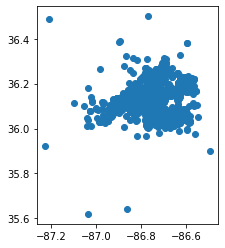

In [16]:
geo_may3_911.plot()